In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for Feature Engineering and Model Validation
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Specific ML model and metric
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error

#### &#10140; *EDA*</br>

In [2]:
trainData = pd.read_csv('../data/train.csv')

print('Data shape: ', trainData.shape)

Data shape:  (1460, 81)


In [3]:
#profile = ProfileReport(trainData, title="Profiling Report")
#profile.to_notebook_iframe()

<div class="alert alert-block alert-success">
<b>Explanation:</b> The 'Id' column is a unique identifier that does not contain predictive information. Removing it prevents data leakage and improves model generalization.
</div>

In [4]:
trainData.drop(['Id'], axis=1, inplace=True)

print(trainData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### -- `Log-Transformation` -- 

<div class="alert alert-block alert-success">
<b>Explanation:</b> The target variable 'SalePrice' is log-transformed using 'log1p' to correct right-skewness and approximate a normal distribution. This transformation stabilizes variance and enhances performance of regression models.
</div>

Text(0.5, 0, 'Log(SalePrice)')

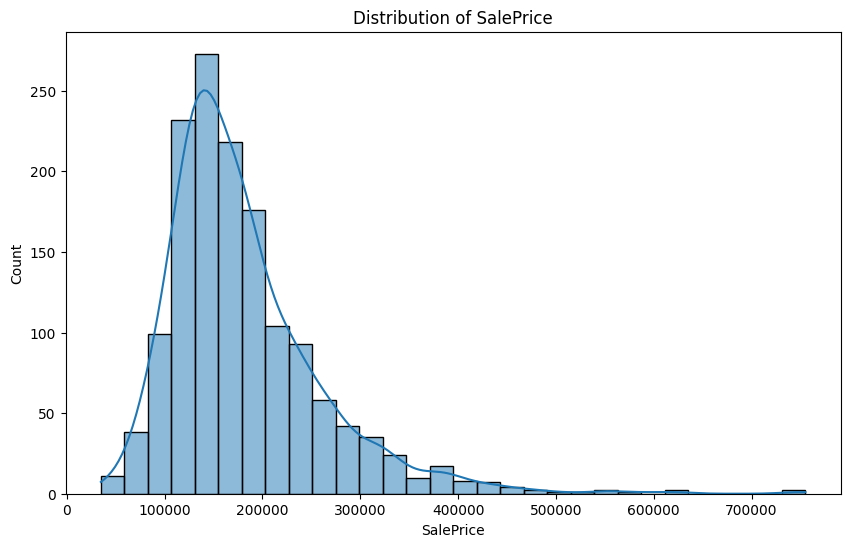

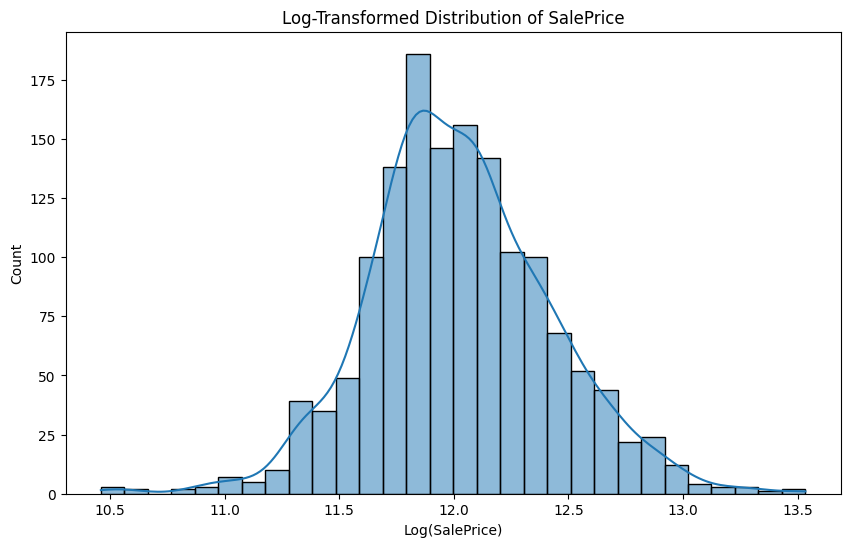

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(trainData['SalePrice'], bins=30, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
 

trainData['SalePrice'] = np.log1p(trainData['SalePrice'])
plt.figure(figsize=(10, 6))
sns.histplot(trainData['SalePrice'], bins=30, kde=True)
plt.title('Log-Transformed Distribution of SalePrice')
plt.xlabel('Log(SalePrice)')

### -- `Missing Data` -- 

In [6]:
missing = trainData.isnull().sum() 
missing = missing[missing > 0].sort_values(ascending=False)

print(missing.head(20))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


<div class="alert alert-block alert-success">
<b>Explanation:</b> Missing data is treated contextually based on feature semantics:

- Categorical features such as 'GarageTyp' or 'BsmtCond' → filled with "None", representing non-existence.
- Numeric structural attributes (areas, counts) → filled with 0.
- Neighborhood-dependent features (e.g., 'LotFrontage') → filled by the median value within the same neighborhood.
- Single-column gaps (e.g., 'Electrical') → filled with the mode.

This tailored imputation preserves real-world meaning and prevents bias in model training.
</div>

In [7]:
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond',
            'MasVnrType']:
    trainData[col] = trainData[col].fillna("None")

for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'MasVnrArea']:
    trainData[col] = trainData[col].fillna(0)

trainData["LotFrontage"] = trainData.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

trainData['Electrical'] = trainData['Electrical'].fillna(trainData['Electrical'].mode()[0])

print(trainData.isnull().sum().sort_values(ascending=False).head(10))

MSSubClass      0
MSZoning        0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64


### -- `Zero Data` -- 

<div class="alert alert-block alert-success">
<b>Explanation:</b> I check how many features are dominated by zero values. This highlights sparsity. I also make a quick correction for 'KitchenAbvGr' by filling any potential missing values with the mode, just to ensure that column is perfect.
</div>

In [8]:
zero_value = trainData.isin([0]).sum()
zero_value = zero_value[zero_value > 0].sort_values(ascending=False)
print(zero_value.head(30))

PoolArea         1453
3SsnPorch        1436
LowQualFinSF     1434
MiscVal          1408
BsmtHalfBath     1378
ScreenPorch      1344
BsmtFinSF2       1293
EnclosedPorch    1252
HalfBath          913
MasVnrArea        869
BsmtFullBath      856
2ndFlrSF          829
WoodDeckSF        761
Fireplaces        690
OpenPorchSF       656
BsmtFinSF1        467
BsmtUnfSF         118
GarageYrBlt        81
GarageCars         81
GarageArea         81
TotalBsmtSF        37
FullBath            9
BedroomAbvGr        6
KitchenAbvGr        1
dtype: int64


In [9]:
trainData['KitchenAbvGr'] = trainData['KitchenAbvGr'].fillna(trainData['KitchenAbvGr'].mode()[0])

### -- `Categorical objects` -- 

<div class="alert alert-block alert-success">
<b>Explanation:</b> Categorical variables are expanded into binary indicator columns using 'OneHotEncoder'.
This representation prevents imposing any artificial ordinal relationship and enables tree-based algorithms like XGBoost to interpret each category independently.
</div>

In [10]:
cat_cols = trainData.select_dtypes(include=["object"]).columns
print(cat_cols)


cat_cols = trainData.select_dtypes(include=["object"]).columns

for col in cat_cols:
    print(f"{col}: {trainData[col].nunique()} unique values")

trainData = pd.get_dummies(trainData, columns=cat_cols)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
MSZoning: 5 unique values
Street: 2 unique values
Alley: 3 unique values
LotShape: 4 unique values
LandContour: 4 unique values
Utilities: 2 unique values
LotConfig: 5 unique values
LandSlope: 3 unique values
Neighborhood: 25 unique values
Condition1: 9 unique values
Condition2: 8 unique values
BldgType: 5 unique values
HouseStyle: 8

### -- `Outliers` -- 

<div class="alert alert-block alert-success">
<b>Explanation:</b> Extreme outliers in area features like 'LotArea' can skew my results. I visualize the data to confirm the worst offenders. I decided to remove houses with excessively large 'GrLivArea' (over 4000 sq ft) and 'LotArea' (over 7500 sq ft). Removing these anomalies improves the model's overall stability and generalization.
</div>

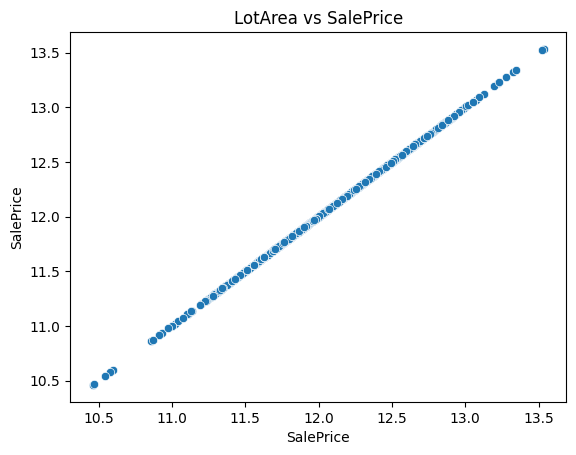

In [11]:
sns.scatterplot(x=trainData['SalePrice'], y=trainData['SalePrice'])
plt.title("LotArea vs SalePrice")

trainData = trainData[trainData['GrLivArea'] < 4000]
trainData = trainData[trainData['LotArea'] < 7500]
trainData = trainData[trainData['GarageYrBlt'] > 1910]

### -- `Feature Engineering` -- 

<div class="alert alert-block alert-success">
<b>Explanation:</b> Two derived features are added to enrich model performance:

- TotalSF: Sum of 1stFlrSF, 2ndFlrSF, and TotalBsmtSF — providing a holistic measure of total livable area.
- Age: Calculated as YrSold - YearBuilt, representing the property’s effective age, a critical pricing factor.

Feature engineering integrates domain intuition into the learning process, improving both interpretability and predictive accuracy.
</div>

In [12]:
trainData['TotalSF'] = trainData['1stFlrSF'] + trainData['2ndFlrSF'] + trainData['TotalBsmtSF']
trainData['Age'] = trainData['YrSold'] - trainData['YearBuilt']

#### &#10140; *Preparing Data*</br>

<div class="alert alert-block alert-success">
<b>Explanation:</b> After data cleaning, imputation, and feature engineering, the dataset is exported to CSV format.
This allows reproducibility, efficient reloading, and ensures identical preprocessing during model training and inference.
</div>

In [13]:
trainData.to_csv("../processed_data/processed_train_data.csv", index=False)

In [15]:
y = trainData['SalePrice']
X = trainData.drop('SalePrice', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

<div class="alert alert-block alert-success">
<b>Explanation:</b> Numerical features are standardized with 'StandardScaler' to achieve consistent scales across columns.
Although scaling is not essential for tree-based models, it enhances interpretability and benefits potential linear baselines or hybrid approaches.
</div>

In [16]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                              columns=X_train.columns, index=X_train.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), 
                             columns=X_valid.columns, index=X_valid.index)  

<div class="alert alert-success">
<b>Explanation — Model:</b><br/>
We use <b>XGBRegressor</b> because gradient-boosted trees are state-of-the-art for tabular data with mixed numeric/categorical features. The model naturally captures non-linearities and high-order interactions, is robust to monotonic feature scaling, and offers strong regularization (depth, subsample, column sampling).
<br/><br/>
<b>Why these hyperparameters:</b>
<ul>
  <li><b>n_estimators=1500</b>: a sufficiently large ensemble to fit complex patterns; combined with shrinkage to avoid overfitting.</li>
  <li><b>learning_rate=0.05</b>: smaller steps improve generalization; more trees then act as a smoother function approximator.</li>
  <li><b>max_depth=4</b>: shallow trees reduce variance and keep interactions interpretable.</li>
  <li><b>subsample=0.6</b>: stochasticity per tree (row sampling) lowers variance and helps against overfitting.</li>
  <li><b>random_state=42</b>: reproducible training.</li>
</ul>
</div>


<div class="alert alert-success">
<b>Explanation — Metric:</b><br/>
We evaluate with <b>RMSLE</b> (Root Mean Squared Logarithmic Error):
<div style="font-family: monospace">RMSLE = sqrt( mean( (log(y_true+1) − log(y_pred+1))^2 ) )</div>
It measures <b>multiplicative</b> error (relative miss), down-weights huge absolute mistakes on expensive houses, and matches the log-transform of the target we use in training/inference.
<br/><br/>
<b>Interpreting a score:</b> For small errors, RMSLE ≈ the typical <i>log-error</i>. Converting back:
<div style="font-family: monospace">typical multiplicative error ≈ exp(RMSLE) − 1</div>
So for <b>RMSLE = 0.105</b> → <b>exp(0.105) − 1 ≈ 0.110</b>. In other words, the model’s predictions deviate by approximately 11% from the true sale prices on average (in a multiplicative sense).
</div>


In [17]:
def rmsle(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)  
    y_pred = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

final_model = XGBRegressor(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=1500,
    subsample=0.6,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

y_pred = final_model.predict(X_valid_scaled)

score = rmsle(y_valid, y_pred)
print(f"RMSLE: {score:.6f}")

RMSLE: 0.105029


<div class="alert alert-success">
<b>Explanation:</b>  
The test dataset must undergo <b>exactly the same preprocessing pipeline</b> as the training data to ensure consistent feature representation.  
All imputation logic (for missing values), categorical encoding, and feature engineering steps are reapplied in identical order.  
<br/><br/>
The most critical step here is <b>feature alignment</b> — reindexing <code>X_test</code> to match <code>X_train</code>’s columns.  
This guarantees that both datasets share the same structure, preventing mismatched columns or unseen categories from breaking the model at inference time.  
Any features absent in the test set are automatically added and filled with zeros, ensuring numerical stability during scaling and prediction.  
<br/><br/>
Finally, the processed test data is standardized using the same <code>StandardScaler</code> fitted on the training data, then exported to <code>processed_test_data.csv</code> for reproducibility and submission.
</div>


In [18]:
testData = pd.read_csv('../data/test.csv')
testData.drop(['Id'], axis=1, inplace=True)

for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond',
            'MasVnrType']:
    testData[col] = testData[col].fillna("None")
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
            'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'MasVnrArea']:
    testData[col] = testData[col].fillna(0)
testData["LotFrontage"] = testData.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
testData['Electrical'] = testData['Electrical'].fillna(testData['Electrical'].mode()[0])
testData['KitchenAbvGr'] = testData['KitchenAbvGr'].fillna(testData['KitchenAbvGr'].mode()[0])

cat_cols = testData.select_dtypes(include=["object"]).columns
for col in cat_cols:
    testData[col] = testData[col].fillna("None")
testData = pd.get_dummies(testData, columns=cat_cols)

testData['TotalSF'] = testData['1stFlrSF'] + testData['2ndFlrSF'] + testData['TotalBsmtSF']
testData['Age'] = testData['YrSold'] - testData['YearBuilt']
X_test = testData.reindex(columns=X_train.columns, fill_value=0)

X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns, index=X_test.index)


print("Test data shape: ", X_test.shape)
testData.to_csv("../processed_data/processed_test_data.csv", index=False)
print("Sucssessfully prepared test data.")

Test data shape:  (1459, 304)
Sucssessfully prepared test data.


<div class="alert alert-block alert-success">
<b>Explanation:</b> I perform the final fit and generate predictions on the prepared test data. The key step is the inverse transformation of predictions using numpy.expm1() to return the values to the original price scale. Finally, I combine the original 'Id' column with the final 'SalePrice' predictions and save the result to submission.csv for the challenge.
</div>

In [19]:
final_model.fit(X_train_scaled, y_train)

test_predictions = final_model.predict(X_test_scaled)

submission = pd.DataFrame({
    'Id': pd.read_csv('../data/test.csv')['Id'],
    'SalePrice': np.expm1(test_predictions)
})
submission.to_csv('../submissions/submission.csv', index=False, float_format='%.10f')
print("Script completed successfully.")

Script completed successfully.


In [25]:
fmodel_filename = "../models/trained_model.pkl"
joblib.dump(final_model, fmodel_filename)

['../models/trained_model.pkl']